<h1 style="color: green;"> Import Library, Load csv file , EDA ,Data manipulation </h1>


In [ ]:
#import all necessary library
import pandas as pd
import langdetect
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import warnings
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.metrics import roc_curve, auc

In [44]:
#load all CSV file
train =pd.read_csv("../offence_data/train.csv")
test = pd.read_csv("../offence_data/test.csv")
valid = pd.read_csv("../offence_data/validation.csv") 
test_lebel = pd.read_csv("../offence_data/test_labels.csv") 


<h1 style="color: green;"> just visualize   train , test, validation a  </h1>

In [12]:
train.head()

,id,feedback_text,toxic,abusive,vulgar,menace,offense,bigotry,word_count,char_count
0,281d77b7bebc2201,:::Sounds good. Let me know when you're done ...,0,0,0,0,0,0,13,68
1,716aac7bf3c63db1,"""\nI say something, but it didn't actually con...",0,0,0,0,0,0,85,413
2,57cb318c6edcf10c,"""Agustina Barrientos]] \n | Modelo de Piñeiro ...",0,0,0,0,0,0,22,173
3,dc3bd70118d91b3a,FYI I enjoy licking strangers scrotal sacks......,1,0,1,0,0,0,10,73
4,cf10d41f2997d233,How do you get a site?\nMany penguins have ask...,0,0,0,0,0,0,88,432


In [13]:
valid.head()

,id,feedback_text,lang,toxic
0,1203,İyi tamam olabilir. Balkanlar maddesini gelişt...,tr,0
1,5871,"Por dios, y la canción de John Lennon: http://...",es,1
2,3590,Selam. Öncelikle tebrik ederim... Bu arada ken...,tr,0
3,447,Leggiti tutte le discussioni. Magari cancellal...,it,1
4,6634,A LAS TOKITAS NOS VALE QUE LAS JONATICAS INSUL...,es,1


In [29]:
test.head()

,id,content,lang,Index
1,56496,"Bahar merhaba, Şu TV programı için bildiğin gi...",tr,1
2,18266,"Merhaba, başlık taşıma nedeniyle bir karışıklı...",tr,2
3,37852,kullanıcı ne mutlu türküm diyene yazmış ta...,tr,3
4,25075,Quand la plaisanterie sur le synopsis de ce fi...,fr,4
5,330,Não fosse seu esclarecimento no blog da Anne (...,pt,5


In [28]:
test['Index'] = range(1, len(test) + 1)

In [33]:
test_lebel['Index'] = range(1, len(test_lebel) + 1)

In [34]:
test_lebel.head()

,id,toxic,Index
0,0,0,1
1,1,0,2
2,2,1,3
3,3,0,4
4,4,0,5


In [35]:
#add test lebel and test data
test = test.merge(test_lebel[['Index', 'toxic']], on='Index', how='left')

In [39]:
test.head()

,id,content,lang,toxic
0,56496,"Bahar merhaba, Şu TV programı için bildiğin gi...",tr,0.0
1,18266,"Merhaba, başlık taşıma nedeniyle bir karışıklı...",tr,0.0
2,37852,kullanıcı ne mutlu türküm diyene yazmış ta...,tr,1.0
3,25075,Quand la plaisanterie sur le synopsis de ce fi...,fr,0.0
4,330,Não fosse seu esclarecimento no blog da Anne (...,pt,0.0


In [38]:
test.drop('Index', axis=1, inplace=True)

In [41]:
test['toxic'] = test['toxic'].fillna(2).astype(int)

In [42]:
test['toxic'] = test['toxic'].astype(int)

<h1 style="color: green;"> Start EDA   </h1>

In [45]:
train.head()

,id,feedback_text,toxic,abusive,vulgar,menace,offense,bigotry
0,281d77b7bebc2201,:::Sounds good. Let me know when you're done ...,0,0,0,0,0,0
1,716aac7bf3c63db1,"""\nI say something, but it didn't actually con...",0,0,0,0,0,0
2,57cb318c6edcf10c,"""Agustina Barrientos]] \n | Modelo de Piñeiro ...",0,0,0,0,0,0
3,dc3bd70118d91b3a,FYI I enjoy licking strangers scrotal sacks......,1,0,1,0,0,0
4,cf10d41f2997d233,How do you get a site?\nMany penguins have ask...,0,0,0,0,0,0


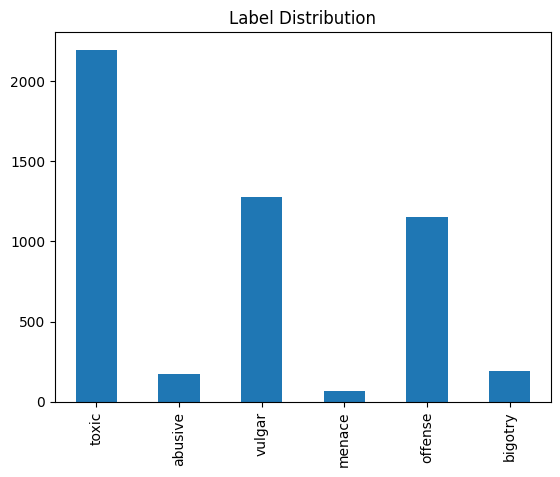

In [5]:
# Step 2: EDA
label_cols = ['toxic', 'abusive', 'vulgar', 'menace', 'offense', 'bigotry']
train[label_cols].sum().plot(kind="bar", title="Label Distribution")
plt.show()



🔍 Missing values:
 id               0
feedback_text    0
toxic            0
abusive          0
vulgar           0
menace           0
offense          0
bigotry          0
dtype: int64

❗ Rows with missing feedback_text: 0


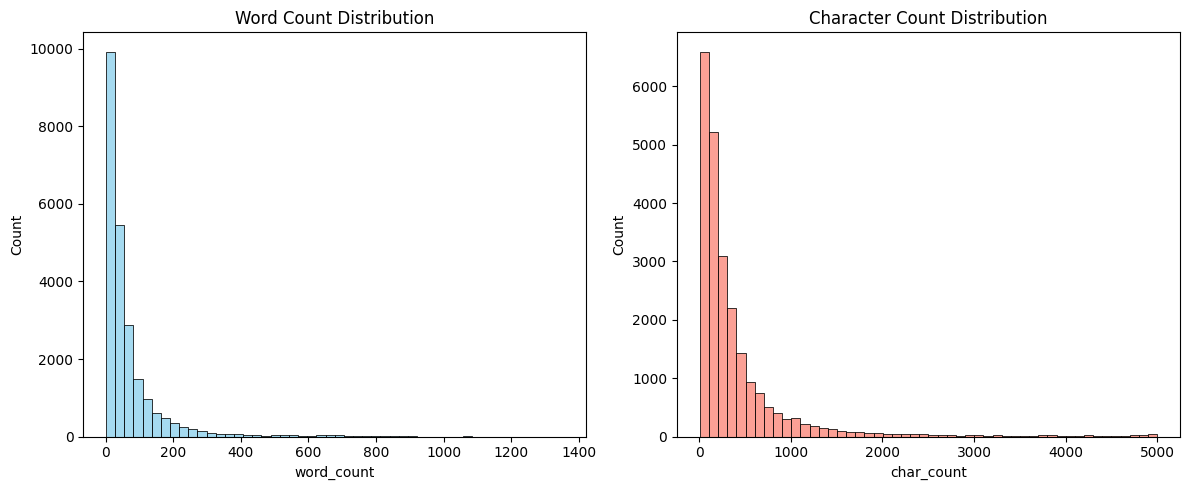

C:\Users\samra\AppData\Local\Temp\ipykernel_572\3661118048.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=common_words_df, x='count', y='word', palette='mako')


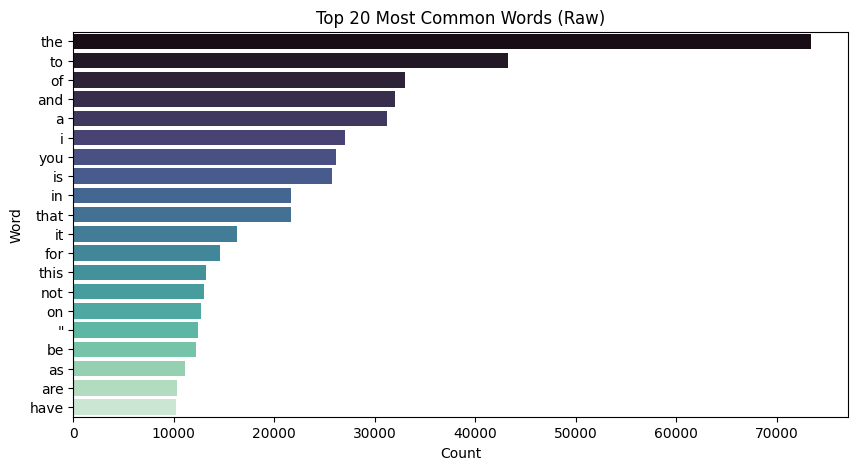

In [6]:
# ================================
# Check for Missing Values
# ================================
print("🔍 Missing values:\n", train.isnull().sum())

# Drop rows with missing feedback_text if any
missing_texts = train[train['feedback_text'].isnull()]
print(f"\n❗ Rows with missing feedback_text: {len(missing_texts)}")
if len(missing_texts) > 0:
    train = train.dropna(subset=['feedback_text'])

# ================================
# Word Distribution and Sentence Length
# ================================
train['word_count'] = train['feedback_text'].apply(lambda x: len(str(x).split()))
train['char_count'] = train['feedback_text'].apply(lambda x: len(str(x)))

# Plot histograms
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(train['word_count'], bins=50, ax=axes[0], color='skyblue')
axes[0].set_title('Word Count Distribution')

sns.histplot(train['char_count'], bins=50, ax=axes[1], color='salmon')
axes[1].set_title('Character Count Distribution')
plt.tight_layout()
plt.show()

# ================================
# Most Common Words (Before Preprocessing)
# ================================
from collections import Counter

all_words = ' '.join(train['feedback_text'].astype(str)).lower().split()
common_words = Counter(all_words)
common_words_df = pd.DataFrame(common_words.most_common(20), columns=['word', 'count'])

# Plot
plt.figure(figsize=(10,5))
sns.barplot(data=common_words_df, x='count', y='word', palette='mako')
plt.title("Top 20 Most Common Words (Raw)")
plt.xlabel("Count")
plt.ylabel("Word")
plt.show()



In [ ]:
#language detection in 
languages = {}
for text in train['feedback_text'].dropna(): # drop NaN values to avoid errors
    try:
        lang = langdetect.detect(text)
        if lang == 'es':
             print(text)
        languages[lang] = languages.get(lang, 0) + 1
    except langdetect.LangDetectException:
            # Handle cases where language detection fails (e.g., short or ambiguous text)
            print(f"Language detection failed for text: '{text}'")
            pass # or use a default language, or add to a count of undetected items.


In [46]:
from langdetect import detect, LangDetectException
import pandas as pd

# Sample DataFrame (replace this with your real one)
# train = pd.read_csv('your_file.csv')

# Create a list to hold detected languages
detected_languages = []

# Iterate through each feedback text
for text in train['feedback_text']:
    if pd.isna(text):
        detected_languages.append(None)
    else:
        try:
            lang = detect(text)
            detected_languages.append(lang)
        except LangDetectException:
            detected_languages.append(None)  # Or use a default like 'unknown'

# Add the language column to the DataFrame
train['lang'] = detected_languages


In [47]:
train.head()

,id,feedback_text,toxic,abusive,vulgar,menace,offense,bigotry,lang
0,281d77b7bebc2201,:::Sounds good. Let me know when you're done ...,0,0,0,0,0,0,en
1,716aac7bf3c63db1,"""\nI say something, but it didn't actually con...",0,0,0,0,0,0,en
2,57cb318c6edcf10c,"""Agustina Barrientos]] \n | Modelo de Piñeiro ...",0,0,0,0,0,0,es
3,dc3bd70118d91b3a,FYI I enjoy licking strangers scrotal sacks......,1,0,1,0,0,0,en
4,cf10d41f2997d233,How do you get a site?\nMany penguins have ask...,0,0,0,0,0,0,en


In [7]:
from nltk.corpus import stopwords

# Load multiple languages
languages = ['english', 'french', 'german', 'spanish', 'portuguese', 'arabic', 'russian']
multi_stop_words = set()
for lang in languages:
    try:
        multi_stop_words.update(stopwords.words(lang))
    except:
        print(f"Stopwords not found for: {lang}")


c:\Users\samra\anaconda3\envs\offence\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128292 (\N{INPUT SYMBOL FOR LATIN LETTERS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


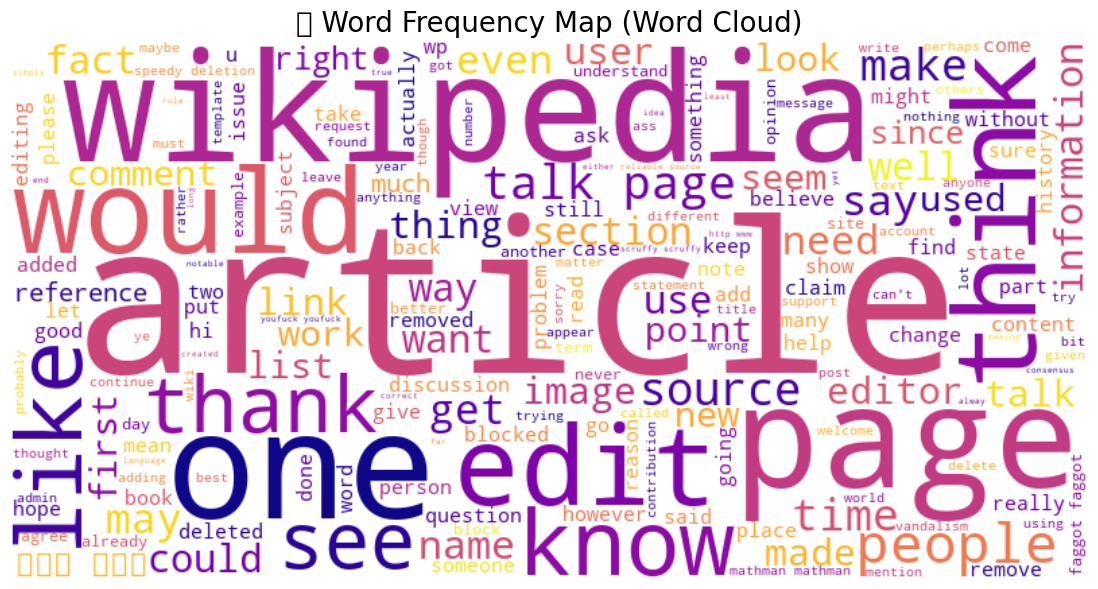

In [8]:
from wordcloud import WordCloud

# Combine all feedback_text into one string
all_text = ' '.join(train['feedback_text'].astype(str)).lower()

# Generate Word Cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=multi_stop_words,
    max_words=200,
    colormap='plasma'
).generate(all_text)

# Plot Word Cloud
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("🔤 Word Frequency Map (Word Cloud)", fontsize=20)
plt.show()


In [9]:
test['lang'].unique()

array(['tr', 'fr', 'pt', 'it', 'ru', 'es'], dtype=object)

In [10]:
valid['lang'].unique()

array(['tr', 'es', 'it'], dtype=object)

In [11]:
#language detection in 
languages = {}
for text in train['feedback_text'].dropna(): # drop NaN values to avoid errors
    try:
        lang = langdetect.detect(text)
        if lang == 'es':
             print(text)
        languages[lang] = languages.get(lang, 0) + 1
    except langdetect.LangDetectException:
            # Handle cases where language detection fails (e.g., short or ambiguous text)
            print(f"Language detection failed for text: '{text}'")
            pass # or use a default language, or add to a count of undetected items.


"Agustina Barrientos]] 
 | Modelo de Piñeiro 
 | Juán Cruz Amigorena 
 |   
 | style=""background:Green;color:#000;""| En Competenciadel Bailando 2012 
 ! 
 | 
 |- 
 | [[B|"
"

 Saloca 

 Hi. This is the pernamently banned user named Perry, from the Spanish Wikipedia. Can you ban Saloca, because of the fact that she is mean to others. This can be proven by the recent ban she gave my IP Address. I want her banned, because she treats other users very poorly.

 Hi. Este es el usuario llamado Perry expulsado permanentemente, a partir de la Wikipedia en español. ¿Se puede prohibir Saloca debido a la hecho de que ella es mezquina para otros. Esto se puede comprobar por la reciente prohibición dio a mi dirección IP. Yo quiero que ella prohibido, porque ella trata a los demás usuarios muy mal.

 Perry "
Can you provide a reference?
Done Jonas 216.241.55.204


KeyboardInterrupt: 

In [ ]:

sorted_data = dict(sorted(languages.items(), key=lambda item: item[1], reverse=True))

print(sorted_data)

{'en': 22601, 'de': 93, 'fr': 70, 'af': 56, 'so': 55, 'id': 50, 'et': 43, 'cy': 37, 'nl': 36, 'no': 34, 'pt': 29, 'es': 28, 'tl': 28, 'tr': 27, 'sv': 27, 'it': 24, 'ro': 22, 'hr': 20, 'da': 20, 'vi': 18, 'ca': 18, 'fa': 15, 'fi': 12, 'hu': 12, 'sq': 11, 'ar': 11, 'sw': 10, 'sk': 9, 'sl': 9, 'pl': 9, 'ru': 6, 'cs': 3, 'el': 3, 'hi': 3, 'bn': 2, 'lt': 2, 'he': 2, 'ko': 2, 'ml': 2, 'zh-cn': 1, 'gu': 1, 'ta': 1, 'th': 1, 'lv': 1, 'mk': 1, 'zh-tw': 1, 'te': 1, 'mr': 1, 'bg': 1}


In [ ]:
valid.head()

,id,feedback_text,lang,toxic
0,1203,İyi tamam olabilir. Balkanlar maddesini gelişt...,tr,0
1,5871,"Por dios, y la canción de John Lennon: http://...",es,1
2,3590,Selam. Öncelikle tebrik ederim... Bu arada ken...,tr,0
3,447,Leggiti tutte le discussioni. Magari cancellal...,it,1
4,6634,A LAS TOKITAS NOS VALE QUE LAS JONATICAS INSUL...,es,1


###just doing trainig test

In [ ]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Download required NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

# Setup
lemmatizer = WordNetLemmatizer()
languages = ['english', 'french', 'german', 'spanish', 'portuguese', 'arabic', 'russian']
multi_stop_words = set()
for lang in languages:
    try:
        multi_stop_words.update(stopwords.words(lang))
    except:
        print(f"Stopwords not found for: {lang}")

# ============================
# Preprocessing Function
# ============================
def preprocess_text(text):
    text = str(text).lower()  # Lowercasing
    text = re.sub(f"[{string.punctuation}]", " ", text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove digits
    tokens = text.split()  # Tokenization
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in multi_stop_words and len(word) > 1]
    return " ".join(tokens)

# Apply Preprocessing
train_df['clean_text'] = train_df['feedback_text'].apply(preprocess_text)
test_df['clean_text'] = test_df['feedback_text'].apply(preprocess_text)


In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)

X = tfidf_vectorizer.fit_transform(train_df['clean_text'])
X_test = tfidf_vectorizer.transform(test_df['clean_text'])

# Target labels
y = train_df[labels]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\samra\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\samra\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



📊 Evaluation on Validation Set (toxic only):
Accuracy: 0.9450
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      4264
           1       0.92      0.44      0.59       431

    accuracy                           0.95      4695
   macro avg       0.93      0.72      0.78      4695
weighted avg       0.94      0.95      0.94      4695

AUC-ROC: 0.9470


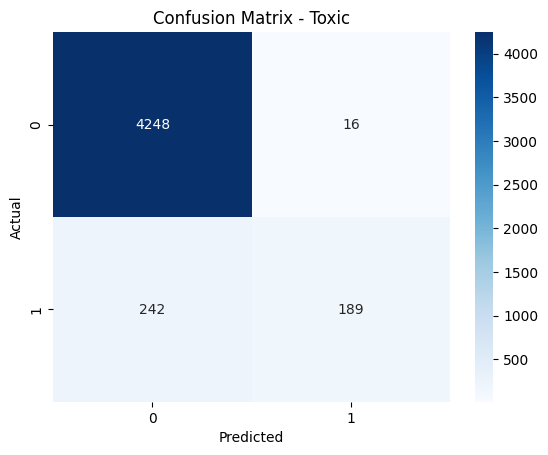


✅ Toxic-only model complete. Predictions saved as 'toxic_only_predictions.csv'


In [ ]:
# ================================
# Offensive Language Classification - Logistic Regression (toxic only)
# ================================

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import warnings

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix

# Setup
warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# ================================
# Load Dataset
# ================================
train_df = pd.read_csv("../offence_data/train.csv") 
test_df = pd.read_csv("../offence_data/validation.csv")  # This has only 'feedback_text' and 'toxic'

# ================================
# Preprocessing
# ================================
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(f"[{string.punctuation}]", "", text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

train_df['clean_text'] = train_df['feedback_text'].apply(preprocess_text)
test_df['clean_text'] = test_df['feedback_text'].apply(preprocess_text)

# ================================
# Train/Test Split
# ================================
X = train_df['clean_text']
y = train_df['toxic']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ================================
# Build Pipeline & Train
# ================================
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=10000)),
    ("clf", LogisticRegression(solver='liblinear'))
])

pipeline.fit(X_train, y_train)

# ================================
# Evaluate on Validation Set
# ================================
y_pred = pipeline.predict(X_val)
y_pred_proba = pipeline.predict_proba(X_val)[:, 1]

print("\n📊 Evaluation on Validation Set (toxic only):")
print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print(classification_report(y_val, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_val, y_pred_proba):.4f}")

# Confusion Matrix
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Toxic")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ================================
# Predict on Test Set
# ================================
test_preds = pipeline.predict(test_df['clean_text'])
test_proba = pipeline.predict_proba(test_df['clean_text'])[:, 1]

# Save Submission
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'toxic': test_preds,
    'toxic_probability': test_proba
})
submission_df.to_csv("toxic_only_predictions.csv", index=False)

print("\n✅ Toxic-only model complete. Predictions saved as 'toxic_only_predictions.csv'")




📊 Evaluation on Test Set (toxic only):
Accuracy: 0.8405
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       706
           1       0.00      0.00      0.00       134

    accuracy                           0.84       840
   macro avg       0.42      0.50      0.46       840
weighted avg       0.71      0.84      0.77       840

AUC-ROC: 0.6225


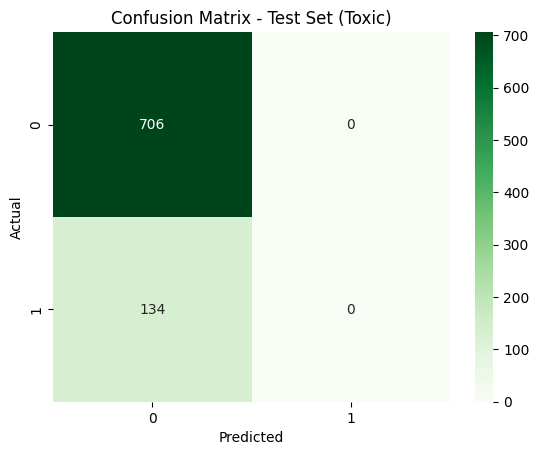


✅ Toxic-only model complete. Predictions saved as 'toxic_only_predictions.csv'


In [ ]:
# ================================
# Predict on Test Set
# ================================
test_preds = pipeline.predict(test_df['clean_text'])
test_proba = pipeline.predict_proba(test_df['clean_text'])[:, 1]

# ✅ Evaluate on Test Set (if it has 'toxic' labels)
if 'toxic' in test_df.columns:
    print("\n📊 Evaluation on Test Set (toxic only):")
    print(f"Accuracy: {accuracy_score(test_df['toxic'], test_preds):.4f}")
    print(classification_report(test_df['toxic'], test_preds))
    print(f"AUC-ROC: {roc_auc_score(test_df['toxic'], test_proba):.4f}")
    
    # Confusion Matrix for Test Set
    sns.heatmap(confusion_matrix(test_df['toxic'], test_preds), annot=True, fmt="d", cmap="Greens")
    plt.title("Confusion Matrix - Test Set (Toxic)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Save Submission
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'toxic': test_preds,
    'toxic_probability': test_proba
})
submission_df.to_csv("toxic_only_predictions.csv", index=False)

print("\n✅ Toxic-only model complete. Predictions saved as 'toxic_only_predictions.csv'")


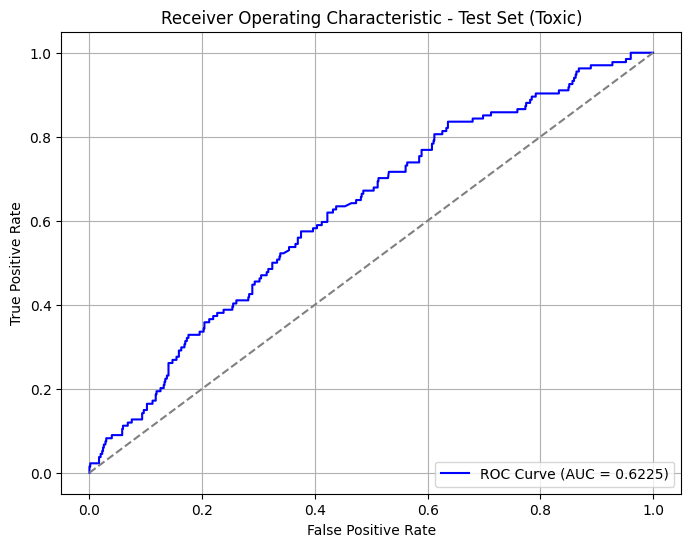

In [ ]:
from sklearn.metrics import roc_curve, auc

# ROC Curve for test set (toxic)
fpr, tpr, thresholds = roc_curve(test_df['toxic'], test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Test Set (Toxic)')
plt.legend(loc='lower right')
plt.grid()
plt.show()
